In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import *
from idlmam import *

/home/ybp/Documentos/repositorios/book_inside_deep_learning_math/idlmam.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### Training a simple loop

In [2]:
def train_simple_network(
        model,
        loss_func, 
        training_loader,
        epochs=20,
        device="cpu"  
    ):
    # Yellow step is done here. Creates the optimizer and moves the model to the compute device. SGD is stochastic gradient descent over the parameters theta
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    model.to(device)
    # The two for loops hanle the red steps, iterating through all the data (batches) multiple times (epochs)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()
        running_loss = 0.0 
        for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):
            # Move the batch of data to the device we are using. Last red step
            inputs = moveTo(inputs, device)
            labels = moveTo(labels, device)
            """
            First a yellow step: prepare the optimizer. Most Pytorch code does this first
            to make sure everything is in a clean and ready state. PyTorch stores gradients
            in a mutable data structure, so we need to set it to a clean state before we use it. 
            Otherwise, it will have old information from a previous iteration
            """
            optimizer.zero_grad()

            # This line and the next perform the two blue steps. 
            y_hat = model(inputs)

            loss = loss_func(y_hat, labels)
            # The remaining two yellow steps compute the gradient and ".step()" the optimizer.
            loss.backward()

            optimizer.step() # Updates all the parameters 

            running_loss += loss.item() # grabs information we would like to have 


### Defining a dataset

<Axes: >

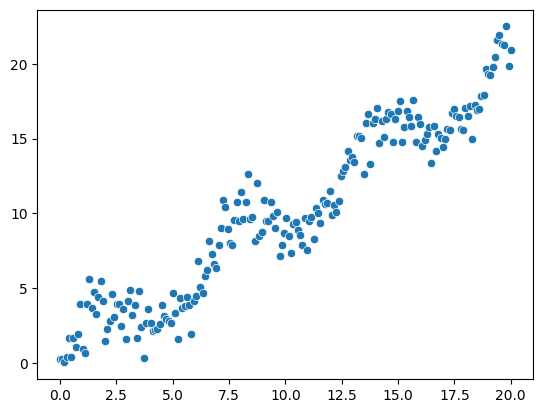

In [3]:
X = np.linspace(0, 20, num=200) 
y = X + np.sin(X)*2 + np.random.normal(size=X.shape)
sns.scatterplot(x=X, y=y)

In [6]:
class Simple1dRegressionDataset(Dataset): 
    def __init__(self, X, y): 
        super(Simple1dRegressionDataset, self).__init__()
        self.X = X.reshape(-1,1)
        self.y = y.reshape(-1,1)
    def __getitem__(self, index):
        return torch.tensor(self.X[index,:], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)
    def __len__(self): 
        return self.X.shape[0]
training_loader = DataLoader(Simple1dRegressionDataset(X,y), shuffle=True)

#### HOw reshape works
![Reshape](images/how_reshape_works.png)


## Putting it together: training a linear regression model on the data

In [7]:
in_features = 1 
out_features = 1 
model = nn.Linear(in_features, out_features)
loss_func = nn.MSELoss()

device = 'cpu'
train_simple_network(model, loss_func, training_loader, device=device)

Epoch: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


<Axes: >

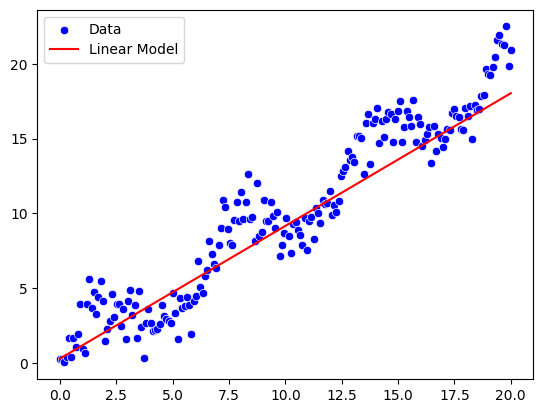

In [8]:
with torch.no_grad():
    Y_pred = model(torch.tensor(X.reshape(-1,1), device=device, dtype=torch.float32)).cpu().numpy()

sns.scatterplot(x=X, y=y, color='blue', label='Data')
sns.lineplot(x=X, y=Y_pred.ravel(), color='red', label='Linear Model')

In [9]:
model = nn.Sequential(
    nn.Linear(1, 10), # Hidden Layer
    nn.Linear(10, 1), # Output layer 
)

train_simple_network(model, loss_func, training_loader, device=device)

Epoch: 100%|██████████| 20/20 [00:03<00:00,  6.40it/s]


<Axes: >

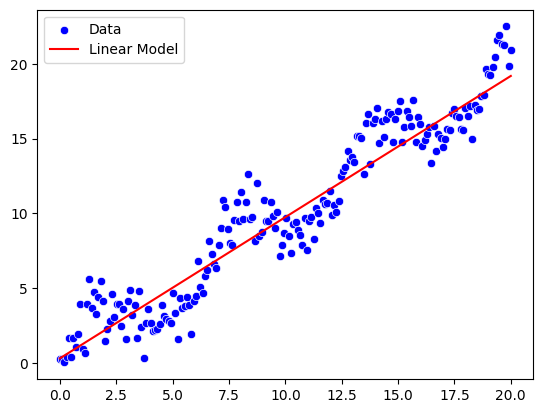

In [10]:
with torch.no_grad():
    Y_pred = model(torch.tensor(X.reshape(-1,1), device=device, dtype=torch.float32)).cpu().numpy()

sns.scatterplot(x=X, y=y, color='blue', label='Data')
sns.lineplot(x=X, y=Y_pred.ravel(), color='red', label='Linear Model')

### Activation functions

Text(0, 0.5, 'Activation')

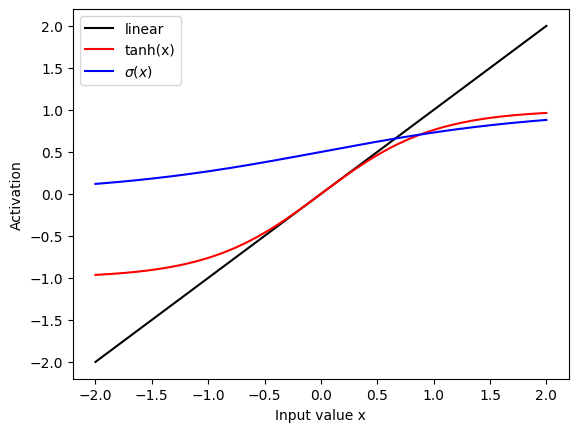

In [11]:
activation_input = np.linspace(-2, 2, num=200)
tanh_activation = np.tanh(activation_input)
sigmoid_activation = np.exp(activation_input)/(np.exp(activation_input)+1)
sns.lineplot(x=activation_input, y=activation_input, color='black', label="linear")
sns.lineplot(x=activation_input, y=tanh_activation, color='red', label="tanh(x)")
ax = sns.lineplot(x=activation_input, y=sigmoid_activation, color='blue', label="$\sigma(x)$")
ax.set_xlabel('Input value x')
ax.set_ylabel('Activation')

In [12]:
model = nn.Sequential(
    nn.Linear(1,  10),#hidden layer
    nn.Tanh(),#activation
    nn.Linear(10, 1),#output layer
)

train_simple_network(model, loss_func, training_loader, epochs=200)

Epoch: 100%|██████████| 200/200 [00:33<00:00,  5.90it/s]


<Axes: >

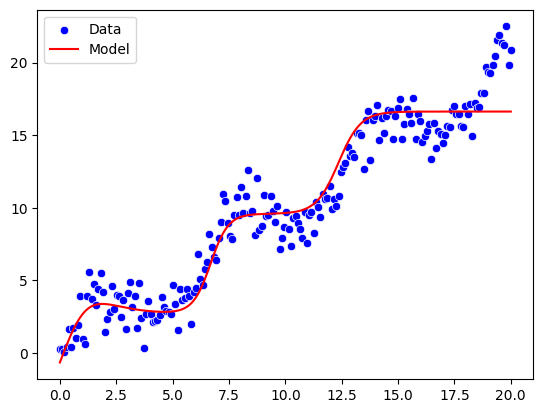

In [13]:
with torch.no_grad():
    Y_pred = model(torch.tensor(X.reshape(-1,1), dtype=torch.float32)).cpu().numpy()
    
sns.scatterplot(x=X, y=y, color='blue', label='Data') #The data
sns.lineplot(x=X, y=Y_pred.ravel(), color='red', label='Model') #What our model learned